In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import date
import datetime
from sklearn import set_config

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import set_config
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [96]:
from sklearn import set_config
set_config(display="diagram")

In [4]:
df_main = pd.read_csv('../data/train_val_data.csv')
df_test = pd.read_csv('../data/test_data.csv')

In [5]:
df_main.rename(columns = {'annual':'salary'}, inplace = True)

In [6]:
df_main.drop(['summed_annual_salary'], inplace=True, axis = 1)
df_test.drop(['summed_annual_salary'], inplace=True, axis = 1)

In [7]:
date_ref = date(2022,1,1)

In [8]:
def experience(list_date, date_base):
    exp = []
    for date_temp in list_date:
        date_res = date_base - datetime.datetime.strptime(date_temp, '%m/%d/%y').date()
        exp.append(abs(date_res.days))       
    return exp

In [9]:
xp_main = experience(list(df_main['hire_date']), date_ref)
xp_test = experience(list(df_test['hire_date']), date_ref)

In [10]:
df_main["experience"] = xp_main
df_test["experience"] = xp_test

In [11]:
df_main['year_hire_date'] = pd.to_datetime(df_main['hire_date']).apply(lambda x: x.year)
df_test['year_hire_date'] = pd.to_datetime(df_test['hire_date']).apply(lambda x: x.year)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_main.drop(['salary'], axis=1), df_main['salary'], test_size=.1, random_state=40)

In [13]:
X = df_main.drop(['salary', 'hire_date'], axis=1)
y = df_main['salary']

### Dirty_cat stuff

In [18]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [15]:
from sklearn.compose import make_column_transformer
encoder = make_column_transformer(
    (one_hot, ['agency_name', 'employee_type', 'rate', 'hrswkd', 'mi', 'ethnicity', 'gender', 'experience']),
    ('passthrough', ['statenum']),
    # Last but not least, our dirty column
    (one_hot, ['class_title']),
    remainder='drop',
    )

In [16]:
from sklearn.experimental import enable_hist_gradient_boosting
# now you can import the HGBR from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

# We then create a pipeline chaining our encoders to a learner
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(encoder, HistGradientBoostingRegressor())

/home/humanum/anaconda3/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [17]:
pipe2 = pipeline.fit(X_train, y_train)

In [18]:
pipe2.score(X_test, y_test)

0.7842625292567951

In [50]:
salary_test_v2 = pipe2.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [54]:
r2 = metrics.r2_score(y_test, salary_test_v2)
mae = mean_absolute_error(y_test, salary_test_v2)
mse = mean_squared_error(y_test, salary_test_v2)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)

r2 : 78.2% 
mean_absolute_error :  6882.38860401214
mean_squared_error :  164464218.56944296


In [45]:
salary_test_v2 = pipe2.predict(df_test)

In [23]:
salary_test_v2

array([94504.47489149, 87767.1878677 , 30768.37681199, ...,
       52675.28490463, 51344.21445666, 44751.65968198])

In [24]:
df_final_v2 = pd.DataFrame(data=salary_test_v2, columns=["predictions"])

In [25]:
df_final_v2

,predictions
0,94504.474891
1,87767.187868
2,30768.376812
3,51880.680255
4,36739.583495
...,...
20727,35213.206970
20728,66722.109224
20729,52675.284905
20730,51344.214457


In [26]:
df_final_v2.to_csv(r'../output/barre_jean_predictions_v1.csv', index=False)

In [ ]:
# SimilarityEncoder(similarity='ngram')
# TargetEncoder(handle_unknown='ignore')
# MinHashEncoder(n_components=100)
# GapEncoder(n_components=100)

In [49]:
from sklearn.compose import make_column_transformer
encoder = make_column_transformer(
    (one_hot, ['agency_name', 'employee_type', 'rate', 'hrswkd', 'mi', 'ethnicity', 'gender', 'experience']),
    ('passthrough', ['statenum']),
    # Last but not least, our dirty column
    (SimilarityEncoder(similarity='ngram'), ['class_title']),
    remainder='drop',
    )

In [58]:
pipeline = make_pipeline(encoder, RandomForestRegressor())

In [59]:
pipe1 = pipeline.fit(X_train, y_train)

In [60]:
salary_predictions = pipe1.predict(X_test)

In [61]:
print("SIMILARITY  RANDOM FOREST: \n")
r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

SIMILARITY  RANDOM FOREST: 

r2 : 95.0% 
mean_absolute_error :  2908.219240911269
mean_squared_error :  37751805.38110907
mean_squared_error sqrt :  6144.249781796722


In [62]:
salary_best = pipe1.predict(df_test)
df_salary_best = pd.DataFrame(data=salary_best, columns=["predictions"])
df_salary_best.to_csv(r'../output/barre_jean_best_predictions.csv', index=False)

In [97]:
pipe1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['agency_name',
                                                   'employee_type', 'rate',
                                                   'hrswkd', 'mi', 'ethnicity',
                                                   'gender', 'experience']),
                                                 ('passthrough', 'passthrough',
                                                  ['statenum']),
                                                 ('similarityencoder',
                                                  SimilarityEncoder(),
                                                  ['class_title'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [128]:
feature_names_1 = pipe1['columntransformer'].transformers_[0][1].get_feature_names()

In [129]:
feature_names_2 = pipe1['columntransformer'].transformers_[2][1].get_feature_names()

In [138]:
feature_names = np.concatenate((feature_names_1, feature_names_2))

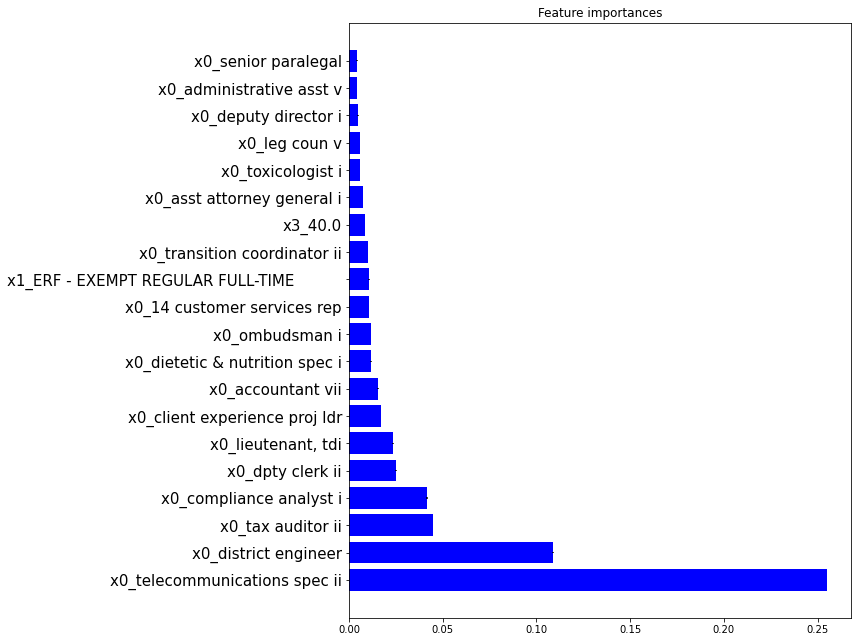

In [140]:

importances = pipe1['randomforestregressor'].feature_importances_
std = np.std(
    [
        tree.feature_importances_
        for tree in pipe1['randomforestregressor'].estimators_
    ],
    axis=0
)
indices = np.argsort(importances)
# Sort from least to most
indices = list(reversed(indices))
plt.figure(figsize=(12, 9))
plt.title("Feature importances")
n = 20
n_indices = indices[:n]
labels = np.array(feature_names)[n_indices]
plt.barh(range(n), importances[n_indices], color="b", yerr=std[n_indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()

# TO DO

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'])

print(f'scores={scores}')
print(f'mean={np.mean(scores)}')
print(f'std={np.std(scores)}')

In [48]:
print("GapEncoder")

r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

GapEncoder
r2 : 92.9% 
mean_absolute_error :  4391.594253259706
mean_squared_error :  53495229.62416974
mean_squared_error sqrt :  7314.043315715989


In [43]:
print("MinHashEncoder")

r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

MinHashEncoder
r2 : 93.3% 
mean_absolute_error :  3908.192700978028
mean_squared_error :  50638953.834070995
mean_squared_error sqrt :  7116.105243324539


In [38]:
print("Target Encoder")

r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

Target Encoder
r2 : 86.6% 
mean_absolute_error :  4813.151579620319
mean_squared_error :  100879274.75547193
mean_squared_error sqrt :  10043.867519808888


In [32]:
#try with date column !!!
print("SIMILARITY : \n")
r2 = metrics.r2_score(y_test, salary_predictions)
mae = mean_absolute_error(y_test, salary_predictions)
mse = mean_squared_error(y_test, salary_predictions)
print("r2 : %0.1f%% " % (r2 * 100))
print("mean_absolute_error : ", mae)
print("mean_squared_error : ", mse)
print("mean_squared_error sqrt : ", np.sqrt(mse))

SIMILARITY : 

r2 : 94.6% 
mean_absolute_error :  3541.567312224181
mean_squared_error :  40659717.804520845
mean_squared_error sqrt :  6376.497299028742


In [27]:
salary_final = pipe1.predict(df_test)
salary_final_df = pd.DataFrame(data=salary_final, columns=["predictions"])
salary_final_df.to_csv(r'../output/barre_jean_predictions_vFBest.csv', index=False)

In [52]:
from sklearn.model_selection import cross_val_score

In [53]:
scores = cross_val_score(pipeline, X, y, scoring='r2', error_score='raise')

In [54]:
scores

array([0.94633666, 0.93834204, 0.94640948, 0.93262791, 0.93988084])

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
from dirty_cat import SuperVectorizer

pipeline = make_pipeline(
    SuperVectorizer(auto_cast=True),
    RandomForestRegressor()
)

In [57]:
pipeX = pipeline.fit(X_train, y_train)
pipeX.score(X_test, y_test)

0.9474773621601138

### Super Vectorizer

In [24]:
from dirty_cat import SuperVectorizer

pipeline = make_pipeline(
    SuperVectorizer(auto_cast=True),
    HistGradientBoostingRegressor()
)

In [24]:
pipe = pipeline.fit(X, y)

In [25]:
pipeX = pipeline.fit(X_train, y_train)
pipeX.score(X_test, y_test)

0.9245369441548479

In [20]:
pipe0 = pipeline.fit(X_train, y_train)

In [21]:
pipe0.score(X_test, y_test)

0.9316879261079826

In [ ]:
#weighted average - compare 

In [43]:
pipe0.score(X_test, y_test)

0.9297636113963772

In [26]:
salary_test = pipe0.predict(X_test)

In [27]:
accuracy = metrics.r2_score(y_test, salary_test)
print("Accuracy: %0.1f%% " % (accuracy * 100))

Accuracy: 92.2% 


In [31]:
mean_squared_error = metrics.mean_squared_error(y_test, salary_test)
print("mean_squared_error: ",mean_squared_error)

mean_squared_error:  58826451.85934164


In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, scoring='r2')

print(f'scores={scores}')
print(f'mean={np.mean(scores)}')
print(f'std={np.std(scores)}')

scores=[0.93533109 0.92455453 0.92632424 0.9239331  0.88331676]
mean=0.9186919430761431
std=0.018156853741499786


In [ ]:
salary_test = pipe0.predict(df_test)

In [27]:
salary_test

array([97922.49101014, 91627.86542003, 24806.06630872, ...,
       51130.70579546, 50200.08540035, 46814.85801104])

In [36]:
df_final_v0 = pd.DataFrame(data=salary_test, columns=["predictions"])

In [38]:
df_final_v0

,predictions
0,97922.491010
1,91627.865420
2,24806.066309
3,56878.988771
4,31576.946317
...,...
20727,31312.869658
20728,78270.574597
20729,51130.705795
20730,50200.085400


In [41]:
df_final_v0.to_csv(r'../output/barre_jean_predictions_v0.csv', index=False)

In [32]:
sup_vec = SuperVectorizer(auto_cast=True)

In [42]:
X_train_enc = sup_vec.fit_transform(X_train, y_train)
X_test_enc = sup_vec.transform(X_test)

In [43]:
X_train_enc

array([[0.0, 0.0, 0.0, ..., 40.0, 338615, 110],
       [1.0, 0.0, 0.0, ..., 40.0, 765444, 2623],
       [1.0, 0.0, 0.0, ..., 20.0, 81895, 1037],
       ...,
       [0.0, 0.0, 0.0, ..., 40.0, 206952, 3287],
       [1.0, 0.0, 0.0, ..., 40.0, 967637, 2098],
       [1.0, 0.0, 0.0, ..., 40.0, 168678, 5601]], dtype=object)

In [44]:
(X_train.shape, X_train_enc.shape)

((105729, 12), (105729, 168))

In [45]:
sup_vec.transformers_

[('low_card_cat',
  OneHotEncoder(),
  ['mi', 'ethnicity', 'gender', 'employee_type']),
 ('high_card_cat',
  GapEncoder(n_components=30),
  ['agency_name', 'class_code', 'class_title', 'hire_date']),
 ('remainder', 'passthrough', [0, 1, 2, 11])]

In [46]:
X.columns.to_list()

['rate',
 'hrswkd',
 'statenum',
 'agency_name',
 'mi',
 'class_code',
 'class_title',
 'ethnicity',
 'gender',
 'employee_type',
 'experience']

In [47]:
feature_names = sup_vec.get_feature_names()
feature_names[:8]

/home/humanum/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['mi_ ', 'mi_A', 'mi_B', 'mi_C', 'mi_D', 'mi_E', 'mi_F', 'mi_G']

In [48]:
len(feature_names)

168

In [49]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train_enc, y_train)

RandomForestRegressor()

In [ ]:
regressor

In [50]:
importances = regressor.feature_importances_
std = np.std(
    [
        tree.feature_importances_
        for tree in regressor.estimators_
    ],
    axis=0
)
indices = np.argsort(importances)
# Sort from least to most
indices = list(reversed(indices))

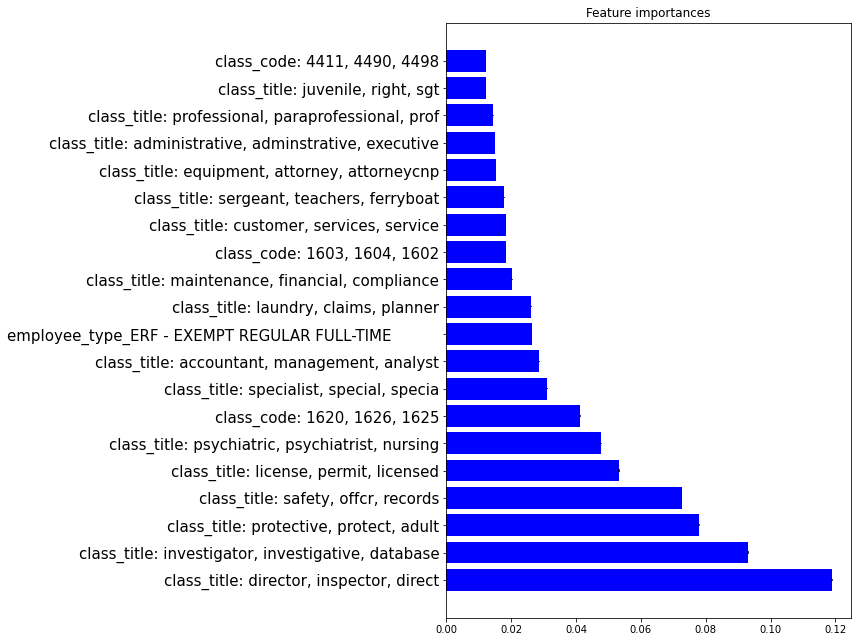

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Feature importances")
n = 20
n_indices = indices[:n]
labels = np.array(feature_names)[n_indices]
plt.barh(range(n), importances[n_indices], color="b", yerr=std[n_indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()

### From scratch stuff

In [37]:
from dirty_cat import SuperVectorizer

pipeline = make_pipeline(
    SuperVectorizer(auto_cast=True),
    HistGradientBoostingRegressor()
)

In [ ]:
pipeX = pipeline.fit(X_train, y_train)
pipeX.score(X_test, y_test)

,rate,hrswkd,statenum,agency_name,mi,class_code,class_title,ethnicity,gender,employee_type,experience,year_hire_date
0,0.0,40.0,17758,texas department of transportation,L,2129,engineering specialist iii,BLACK,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,4232,2010
1,0.0,40.0,80987,health and human services commission,G,1325,inspector v,BLACK,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,1583,2017
2,0.0,40.0,18023,department of public safety,,0174,license and permit spec v,HISPANIC,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,3610,2012
3,0.0,40.0,1269844,texas department of transportation,,9305,trans maint spec i,HISPANIC,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,558,2020
4,0.0,40.0,184217,department of family and protective services,G,0156,administrative asst iv,HISPANIC,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,8919,1997
...,...,...,...,...,...,...,...,...,...,...,...,...
117472,0.0,40.0,1133599,texas department of criminal justice,O,4504,correc officer iv,BLACK,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,1223,2018
117473,0.0,40.0,1198238,texas department of criminal justice,A,4541,parole offcr ii,HISPANIC,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,894,2019
117474,0.0,40.0,979572,employees retirement system,R,0222,it business analyst ii,WHITE,FEMALE,CRF - CLASSIFIED REGULAR FULL-TIME,2025,2016
117475,0.0,40.0,97069,department of public safety,M,9940,"sergeant, dps",WHITE,MALE,CRF - CLASSIFIED REGULAR FULL-TIME,2044,2016
